# Create a mock area for the planning units

The example of planning units we have lacks a pu.shp to match it.\
Create a gridded shapefile to visualize results

In [2]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd

### Get a country polygon

<AxesSubplot:>

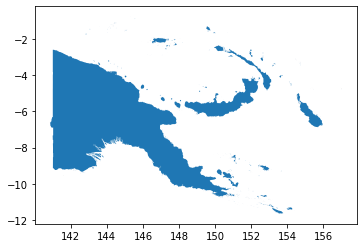

In [72]:
# Get Kenya gadm
# gadm = gpd.read_file('../../datasets/data_for_features/gadm36_0.shp')
# gadm.head()
# country = gadm[gadm['NAME_0']=='Kenya']
country = gadm[gadm['GID_0']=='PNG']
country.to_file('../../datasets/data_for_features/PNG_gadm36_0.geojson',driver='GeoJSON')
country = gpd.read_file('../../datasets/data_for_features/PNG_gadm36_0.geojson')
country.plot()

### Make a SQUARE grid over the length of the country

In [86]:
def create_grid(source_gdf, resolution_km, export=False):
    #'Add terrestrial, marine, both extension'
    
    # convert source_gdf to crs in m
    if source_gdf.crs != 'EPSG:3857':
        source_gdf=source_gdf.to_crs(epsg=3857)
    
    # generate bounding box for grid
    xmin,ymin,xmax,ymax = source_gdf.total_bounds

    # set resolution (cell size) to meters
    length = resolution_km*1000
    width = resolution_km*1000

    # define how many columns and rows are in the grid
    cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
    if cols[-1]<1:
        cols.append(cols[-1]-width)
    else:
        cols.append(cols[-1]+width)
    rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
    if rows[-1]<1:
        rows.append(rows[-1]-length)
    else:
        rows.append(rows[-1]+length)
    rows.reverse()

    # create grid of polygons
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+width, y), (x+width, y-length), (x, y-length)]) )

    # turn grid into geodataframe, assign same coordinate system than source layer
    grid = gpd.GeoDataFrame({'geometry':polygons}).set_crs(epsg=3857)
    grid['id']=grid.index

    
    # clip to extent of source_gdf
    grid_clip = gpd.clip(grid, source_gdf)
    
    # export to file
    if export == True:
        grid_clip.to_file(f'../../datasets/data_for_features/grid_clip_{resolution_km}km.geojson',driver='GeoJSON')
        grid.to_file(f'../../datasets/data_for_features/grid_{resolution_km}km.geojson',driver='GeoJSON')
    else:
        pass
    
    return grid_clip

In [75]:
grid_clip = create_grid(country,5, export=True)

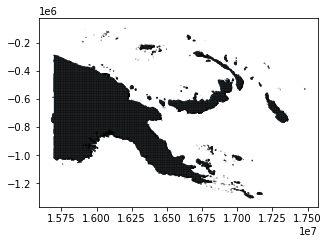

In [90]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')
country.to_crs(epsg=3857).plot(ax=ax)
grid_clip.plot(ax=ax,edgecolor='black',color= 'white',alpha=0.5)
plt.show()

In [89]:
len(grid)

89052

### Make a HEXAGONAL grid over the length of the country (WIP)

In [4]:
import math
#https://gist.github.com/urschrei/17cf0be92ca90a244a91

def calculate_polygons(startx, starty, endx, endy, radius):
    """ 
    Calculate a grid of hexagon coordinates of the given radius
    given lower-left and upper-right coordinates 
    Returns a list of lists containing 6 tuples of x, y point coordinates
    These can be used to construct valid regular hexagonal polygons
    
    You will probably want to use projected coordinates for this
    """
    # calculate side length given radius   
    sl = (2 * radius) * math.tan(math.pi / 6)
    # calculate radius for a given side-length
    # (a * (math.cos(math.pi / 6) / math.sin(math.pi / 6)) / 2)
    # see http://www.calculatorsoup.com/calculators/geometry-plane/polygon.php
    
    # calculate coordinates of the hexagon points
    # sin(30)
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl
    
    # offset start and end coordinates by hex widths and heights to guarantee coverage     
    startx = startx - w
    starty = starty - h
    endx = endx + w
    endy = endy + h

    origx = startx
    origy = starty


    # offsets for moving along and up rows
    xoffset = b
    yoffset = 3 * p

    polygons = []
    row = 1
    counter = 0

    while starty < endy:
        if row % 2 == 0:
            startx = origx + xoffset
        else:
            startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty + p
            p2x = startx
            p2y = starty + (3 * p)
            p3x = startx + b
            p3y = starty + h
            p4x = startx + w
            p4y = starty + (3 * p)
            p5x = startx + w
            p5y = starty + p
            p6x = startx + b
            p6y = starty
            poly = [
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p5x, p5y),
                (p6x, p6y),
                (p1x, p1y)]
            polygons.append(poly)
            counter += 1
            startx += w
        starty += yoffset
        row += 1
    return polygons

In [5]:
kenya_m = kenya.to_crs(epsg=3857)
xmin,ymin,xmax,ymax = kenya_m.total_bounds
#https://hexagoncalculator.apphb.com/

#radius = center to vertex, not apothem
radius = 6.2040 #100a2
# radius = 4.3869 #50a2
# radius = 1.9619 #10a2

hexagrid = calculate_polygons(startx=xmin, starty=ymin, endx=xmax, endy=ymax, radius=radius)
#When using projected grid, something happens and it collapses

In [6]:
df = pd.DataFrame(columns = ['id','pu'])
for i in range(len(hexagrid)):
    new_row = {'id':i, 'pu':hexagrid[i]}
    df=df.append(new_row, ignore_index=True)

In [7]:
from shapely.geometry import Point

df['geometry'] = df.pu.apply(Polygon)
gdf = gpd.GeoDataFrame(df).set_crs(epsg=3857)

<AxesSubplot:>

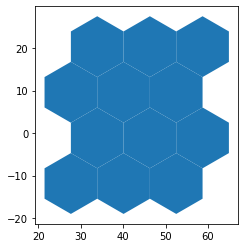

In [8]:
gdf.plot()

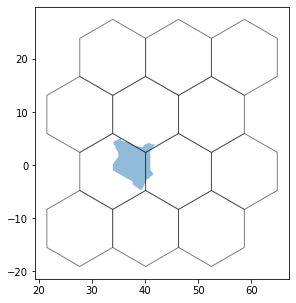

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')
kenya.plot(ax=ax)
gdf.plot(ax=ax,edgecolor='black',color= 'white',alpha=0.5)
plt.show()

### Assign planning units to the grid cells

To be able to visualize the results from the marxan example

In [91]:
## Read grid
grid_clip = gpd.read_file('../../datasets/data_for_features/grid_PNG_5km.geojson')

## Create new column for index 
grid_clip['puid'] = range(1, len(grid_clip) + 1)

## Delete previous index
grid_clip = grid_clip.drop(columns=['id'])

## Plot grid
# grid_clip.plot(edgecolor='black',color='white',figsize=(10,10))

In [92]:
grid_clip

,geometry,puid
0,"POLYGON ((15678292.000 -91514.000, 15683292.00...",1
1,"POLYGON ((15678292.000 -86514.000, 15683292.00...",2
2,"POLYGON ((15678292.000 -91514.000, 15683292.00...",3
3,"POLYGON ((15678292.000 -96514.000, 15683292.00...",4
4,"POLYGON ((15678292.000 -101514.000, 15683292.0...",5
...,...,...
89047,"POLYGON ((17483292.000 -1286514.000, 17488292....",89048
89048,"POLYGON ((17483292.000 -1291514.000, 17488292....",89049
89049,"POLYGON ((17483292.000 -1296514.000, 17488292....",89050
89050,"POLYGON ((17483292.000 -1301514.000, 17488292....",89051
